In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [86]:
data = pd.read_csv('migration_nz.csv')
data.head(10)

,Measure,Country,Citizenship,Year,Value
0,Arrivals,Oceania,New Zealand Citizen,1979,11817.0
1,Arrivals,Oceania,Australian Citizen,1979,4436.0
2,Arrivals,Oceania,Total All Citizenships,1979,19965.0
3,Arrivals,Antarctica,New Zealand Citizen,1979,10.0
4,Arrivals,Antarctica,Australian Citizen,1979,0.0
5,Arrivals,Antarctica,Total All Citizenships,1979,13.0
6,Arrivals,American Samoa,New Zealand Citizen,1979,17.0
7,Arrivals,American Samoa,Australian Citizen,1979,4.0
8,Arrivals,American Samoa,Total All Citizenships,1979,30.0
9,Arrivals,Australia,New Zealand Citizen,1979,8224.0


In [87]:
data['Measure'].unique()

array(['Arrivals', 'Departures', 'Net'], dtype=object)

In [88]:
# data['Measure'].replace("Arrivals",0,inplace=True)
# data['Measure'].replace("Departures",1,inplace=True)
# data['Measure'].replace("Net",2,inplace=True)
data['Measure'].replace({"Arrivals": 0, "Departures": 1, "Net": 2}, inplace=True)

# Factorize Country and Citizenship
data['CountryID'] = pd.factorize(data['Country'])[0]
data['CitID'] = pd.factorize(data['Citizenship'])[0]

# Fill missing 'Value' with median
data['Value'].fillna(data['Value'].median(), inplace=True)

# Drop unnecessary columns
data.drop(['Country', 'Citizenship'], axis=1, inplace=True)


C:\Users\agraw\AppData\Local\Temp\ipykernel_3964\2904686749.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Measure'].replace({"Arrivals": 0, "Departures": 1, "Net": 2}, inplace=True)
C:\Users\agraw\AppData\Local\Temp\ipykernel_3964\2904686749.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tru

In [89]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(data[['CountryID', 'Measure', 'Year', 'CitID']])

# Define target
Y = data['Value']

#  Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_poly, Y, test_size=0.3, random_state=42
)

In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [91]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=70,max_features = 3,max_depth=5,n_jobs=-1)
rf.fit(X_train ,y_train)
rf.score(X_test, y_test)

0.68858469565993

In [92]:
# Model Training with GradientBoosting
gb_model = GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.2)
gb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = gb_model.predict(X_test)
print("Gradient Boosting R2 Score:", r2_score(y_test, y_pred))
print("Gradient Boosting RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Advanced Model - XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1)
xgb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

Gradient Boosting R2 Score: 0.9403224594548373
Gradient Boosting RMSE: 777.3192358233263
XGBoost R2 Score: 0.8901423101639138
XGBoost RMSE: 1054.6520176953393


In [93]:
print("GB  :",gb_model.score(X_test,y_test))
print("XBG :",xgb_model.score(X_test,y_test))

GB  : 0.9403224594548373
XBG : 0.8901423101639138


C:\Users\agraw\AppData\Roaming\Python\Python311\site-packages\IPython\core\completerlib.py:120: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  rootmodules_cache = ip.db.get('rootmodules_cache', {})
C:\Users\agraw\AppData\Roaming\Python\Python311\site-packages\IPython\core\completerlib.py:120: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  rootmodules_cache = ip.db.get('rootmodules_cache', {})


In [94]:
"""Gradient Boosting R2 Score: 0.9070220064371526
Gradient Boosting RMSE: 970.2508721411192"""
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}


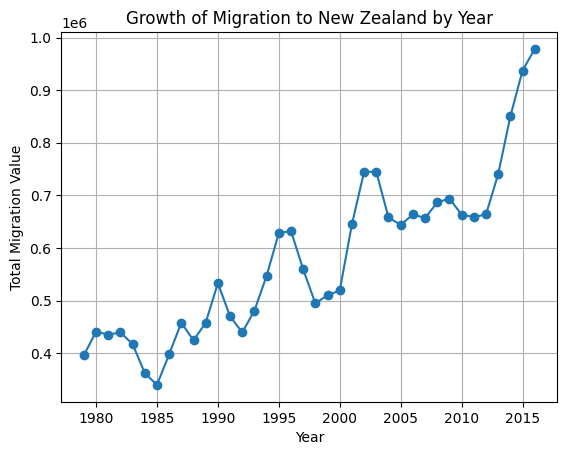

In [95]:
#Plot Migration Growth over Years
grouped = data.groupby('Year')['Value'].sum()
grouped.plot(kind='line', marker='o')
plt.title("Growth of Migration to New Zealand by Year")
plt.xlabel("Year")
plt.ylabel("Total Migration Value")
plt.grid(True)
plt.show()

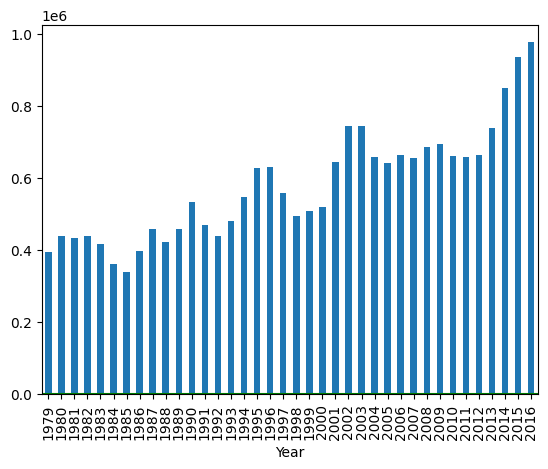

In [96]:
grouped.plot(kind='bar');plt.axhline(0, color='g')
plt.show()

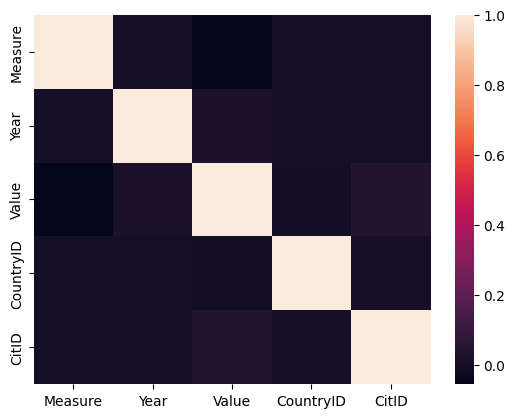

In [97]:
corr = data.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.show()

In [98]:
# Save the fitted scaler
import joblib

joblib.dump(scaler, 'models/scaler.pkl')

# Save trained models
joblib.dump(rf, 'models/random_forest_model.pkl')
joblib.dump(gb_model, 'models/gradient_boosting_model.pkl')
joblib.dump(xgb_model, 'models/xgboost_model.pkl')

print("Models and scaler saved successfully!")


Models and scaler saved successfully!
